In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
import pickle
import multiprocessing as mp  

Using TensorFlow backend.
C:\Users\felip\Anaconda3\envs\DigitalAg\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\felip\Anaconda3\envs\DigitalAg\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\felip\Anaconda3\envs\DigitalAg\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\felip\Anaconda3\envs\Digit

In [2]:
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Benign','Bot']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

In [3]:
def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

In [4]:
#Load the data
np.random.seed(123)

data = pd.read_csv('C:/MSc_Felippe/CSC7333_Project/data/Friday-WorkingHours-Morning.pcap_ISCX.csv', 
                   na_values = ["NaN", "Infinity"], header = 0)


old_names=list(data.columns)
new_names=list(data.columns.str.replace(" ", ""))



cols = {old_names[i]: new_names[i] for i in range(len(old_names))} 
data = data.rename(columns=cols)

data = data.drop(columns=['DestinationPort'])
data.head(5)

,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,112740690,32,16,6448,1152,403,0,201.5,204.724205,72,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,112740560,32,16,6448,5056,403,0,201.5,204.724205,316,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,113757377,545,0,0,0,0,0,0.0,0.000000,0,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,100126,22,0,616,0,28,28,28.0,0.000000,0,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,54760,4,0,0,0,0,0,0.0,0.000000,0,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [5]:
data = data.dropna()
#data.isna().sum()

In [6]:
#Present the shape of the data
print('The shape of our features is:', data.shape)

data.Label.value_counts()

The shape of our features is: (190911, 78)


BENIGN    188955
Bot         1956
Name: Label, dtype: int64

In [7]:
#Extract the values to be predicted
y_data = np.array(data['Label'])

#Bening is 0 and Bot is 1
y_data = pd.factorize(y_data)[0]

#Delete the values to be predicted from the original data frame
X_data = data.drop('Label', axis = 1)

In [8]:
# Split the data into training and testing sets
X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=123)

print('Training Features Shape:', X.shape)
print('Testing Features Shape:', X_test.shape)
print('Training Labels Shape:', y.shape)
print('Test Labels Shape:', y_test.shape)

Training Features Shape: (133637, 77)
Testing Features Shape: (57274, 77)
Training Labels Shape: (133637,)
Test Labels Shape: (57274,)


In [9]:
#Set values to be used on GridSearchCV
param_grid = { 
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    'criterion': ['gini', 'entropy'], 
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf' : [len(X)//10000, len(X)//28000, 
                          len(X)//50000, len(X)//100000],
    'bootstrap': [True, False]
}

In [10]:
pre = RandomForestClassifier(n_jobs=-1, random_state = 123,
                             max_features= 'sqrt', 
                             criterion = 'entropy')

CV_rfc = RandomizedSearchCV(estimator=pre, 
                      param_distributions=param_grid, 
                      scoring = 'recall',
                      n_iter=100,
                      cv=10, 
                      n_jobs=mp.cpu_count(),
                      verbose=3,
                      pre_dispatch='2*n_jobs')

CV_rfc.fit(X, y)

CV_rfc.best_params_

#{'n_estimators': 1800,'min_samples_split': 2,'min_samples_leaf': 1,'max_features': 'auto','max_depth': 90,'criterion': 'entropy','bootstrap': True}

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  2.4min
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed: 38.2min
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed: 87.2min
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed: 171.9min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed: 267.7min
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed: 353.8min finished


{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'criterion': 'entropy',
 'bootstrap': True}

In [15]:
rfc = RandomForestClassifier(n_jobs=-1, random_state = 123,
                             n_estimators=CV_rfc.best_params_['n_estimators'], 
                             criterion=CV_rfc.best_params_['criterion'],
                             max_depth=CV_rfc.best_params_['max_depth'],
                             min_samples_split=CV_rfc.best_params_['min_samples_split'],
                             min_samples_leaf=CV_rfc.best_params_['min_samples_leaf'], 
                             max_features= CV_rfc.best_params_['max_features'],
                             bootstrap=CV_rfc.best_params_['bootstrap']
                            )

In [16]:
#Balance the data
smote = SMOTE(random_state=123)
X_res, y_res = smote.fit_sample(X, y)

values, counts = np.unique(y_res, axis=0, return_counts=True)
counts

array([132266, 132266], dtype=int64)

In [19]:
# Saving feature names for later use
variable_list = list(X_res.columns)

X_res=np.array(X_res)

In [24]:
#Implementing Stratified K fold CV
accuracy=[]
gkf=RepeatedKFold(n_splits=10, random_state=123)
gkf.get_n_splits(X_res,y_res)
for train_index, val_index in gkf.split(X_res,y_res):
    X_train, X_val = X_res[train_index], X_res[val_index]
    y_train, y_val = y_res[train_index], y_res[val_index]
    
    #X_norm_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
    
    rfc.fit(X_train,y_train)
    
    #X_norm_val = pd.DataFrame(StandardScaler().fit_transform(X_val))
    
    predictions = rfc.predict(X_val)
    
    score_=accuracy_score(predictions,y_val)
    accuracy.append(score_)
    
print(accuracy)

[0.9992817721327587, 0.999168367732668, 0.999206139190262, 0.9992439420859638, 0.9990927305031565, 0.9993573507730692, 0.9990927305031565, 0.9993951536687711, 0.999206139190262, 0.9992439420859638, 0.9989793603991834, 0.9990549633325773, 0.9990927305031565, 0.999206139190262, 0.9993951536687711, 0.9994329565644728, 0.9993951536687711, 0.9991305333988584, 0.9992817449816656, 0.9989415189203493, 0.9992817721327587, 0.9992061691993649, 0.999206139190262, 0.9990549276074547, 0.9995085623558765, 0.999017124711753, 0.999206139190262, 0.9993573507730692, 0.9991305333988584, 0.9993573507730692, 0.9993195735994557, 0.9992439706660619, 0.999017124711753, 0.9996975768343855, 0.9992439420859638, 0.9992817449816656, 0.9990927305031565, 0.9993951536687711, 0.9991683362945601, 0.999206139190262, 0.9992439706660619, 0.9992439706660619, 0.9994707594601746, 0.9994329565644728, 0.9991305333988584, 0.9988659131289457, 0.9994329565644728, 0.9989037160246474, 0.9994329565644728, 0.9989037160246474, 0.999092

In [25]:
#Accuracy evaluation
np.array(accuracy).mean()

0.9992367653232503

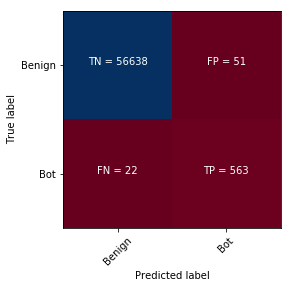

Recall=0.962 
Precision=0.917
F1=0.939
Average precision-recall score: 0.982


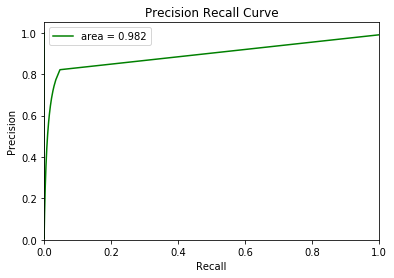

In [28]:
#X_norm_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns = X_test.columns)


y_pred = rfc.predict(X_test)
try:
    scores = rfc.decision_function(X_test)
except:
    scores = rfc.predict_proba(X_test)[:,1]

#Make plots
plot_cm(rfc, y_pred)
plot_aucprc(rfc, scores)

In [29]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = variable_list,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.to_csv('C:/MSc_Felippe/CSC7333_Project/results/RF_Importance_Analysis/RF_Feature_Importance.csv', sep=',', encoding='utf-8')

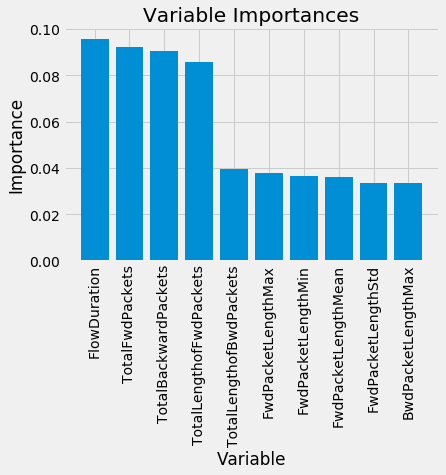

In [30]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(feature_importances[:10])))

# Make a bar chart
plt.bar(x_values, feature_importances['importance'][:10], orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, variable_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

plt.savefig('C:/MSc_Felippe/CSC7333_Project/results/RF_Importance_Analysis/Variable_Importances.png', bbox_inches="tight", dpi = 300)

In [31]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(rfc, open(filename, 'wb'))